# **Chapter 2: Next-Generation Sequencing**
</br>

**Working with BAM files**

Description of BAM files: </br>
Before you start coding, note that you can inspect the BAM file using `samtools view -h`. </br>We suggest that you take a
look at the header file and the first few records. </br>
One of the most complex operations in NGS is to generate good alignment
files from raw sequence data. It not only calls the aligner, but also cleans
up data. Now, in the @PG headers of high quality BAM files, you will find
the actual command lines used for most, if not all, of the procedures used
to generate this BAM file. In our example BAM file, you will find all the
information needed to run bwa, SAMtools, the GATK IndelRealigner, and
the Picard application suite to clean up data. Remember that while you
can generate BAM files easily, the programs after it will be quite picky in
terms of correctness of the BAM input. For instance, if you use GATK's
variant caller to generate genotype calls, the files will have to be
extensively cleaned. The header of other BAM files can thus provide you
with the best way to generate yours. A final recommendation is that if you
do not work with human data, try to find good BAMs for your species,
because the parameters of a given program may be slightly different.
Also, if you use something other than the WGS data, check for similar
types of sequencing data.

**Let's take a look at the following steps:**

In [2]:
pip install pysam    #  a Python wrapper to the SAMtools C API

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 7.9 MB/s 


In [3]:

from collections import defaultdict

import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pysam

1. Let's inspect the header files: </br>
You just need to do this only once

In [1]:
!rm -f NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam 2>/dev/null
!rm -f NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam.bai 2>/dev/null
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/exome_alignment/NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/exome_alignment/NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam.bai

--2022-07-16 18:28:39--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/NA18489/exome_alignment/NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam
           => ‘NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.140
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.140|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/phase3/data/NA18489/exome_alignment ... done.
==> SIZE NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam ... 327067172
==> PASV ... done.    ==> RETR NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam ... done.
Length: 327067172 (312M) (unauthoritative)

NA18489.chrom20.ILL 100%[===================>] 311.92M  21.7MB/s    in 16s     

2022-07-16 18:28:57 (19.6 MB/s) - ‘NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam’ saved [327067172]

--2022-07-16 18:28:57--  f

In [4]:
bam = pysam.AlignmentFile('NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam', 'rb')

In [5]:
headers = bam.header
for record_type, records in headers.items():
    print (record_type)
    for i, record in enumerate(records):
        if type(record) == dict:
            print('\t%d' % (i + 1))
            for field, value in record.items():
                print('\t\t%s\t%s' % (field, value))
        else:
            print('\t\t%s' % record)

HD
		VN
		SO
SQ
	1
		SN	1
		LN	249250621
		M5	1b22b98cdeb4a9304cb5d48026a85128
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	2
		SN	2
		LN	243199373
		M5	a0d9851da00400dec1098a9255ac712e
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	3
		SN	3
		LN	198022430
		M5	fdfd811849cc2fadebc929bb925902e5
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	4
		SN	4
		LN	191154276
		M5	23dccd106897542ad87d2765d28a19a1
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	5
		SN	5
		LN	180915260
		M5	0740173db9ffd264d728f32784845cd7
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_as

The header is represented as a dictionary (where the key is the record_type). As
there can be several instances of the same record_type, the value of the
dictionary is a list (where each element is, again, a dictionary, or sometimes a
string containing tag/value pairs).</br>
We will now inspect a single record. The amount of data per record is quite
complex. Here, we will focus on some of the fundamental fields for paired-end
reads. Check the SAM file specification and the pysam API documentation for
more details:

**Description of following codes:** </br>
Note that the BAM file object is iterable over its records. We will transverse it until we find a record whose CIGAR string contains a match and a soft clip.
</br>
The CIGAR string gives an indication of the alignment of individual bases. The
clipped part of the sequence is the part that the aligner failed to align (but is not removed from the sequence). We will also want the read, its mate ID, and position (of the pair, as we have paired-end reads) that was mapped to the reference genome.
</br>
First, we print the query template name, followed by the reference ID. The
reference ID is a pointer to the name of the sequence on the given references on
the lookup table of references. An example will make this clear. For all records on this BAM file, the reference ID is 19 (a non-informative number), but if you apply bam.getrname(19), you will get 20, which is the name of the chromosome. So, do not confuse the reference ID (in this case, 19 ) with the name of the chromosome (20). This is then followed by the reference start and reference end. pysam is 0-based, not 1-based. So, be careful when you convert coordinates to other libraries. You will notice that the start and end for this case is 59,996 and 60,048, which means an alignment of 52 bases. Why is there only 52 bases when the read size is 76 (remember, the read size used in this BAM file)? </br>
The answer can be found on the CIGAR string, which in our case will be 52M24S, which is a 52 bases match, followed by 24 bases that were soft-clipped.
</br>
Then, we print where the alignment starts and ends and calculate its length. By
the way, you can compute this by looking at the CIGAR string. It starts at 0 (as the first part of the read is mapped) and ends at 52. The length is 76 again.
</br>
Now, we query the mate (something that you will only do if you have paired-end
reads). We get its reference ID (as shown in the previous code), its start position, and a measure of the distance between both pairs. This measure of distance only makes sense if both mates are mapped to the same chromosome.

In [6]:
#0-based
for rec in bam:
    if rec.cigarstring.find('M') > -1 and rec.cigarstring.find('S') > -1 and not rec.is_unmapped and not rec.mate_is_unmapped:
        break
print(rec.query_name, rec.reference_id, bam.getrname(rec.reference_id), rec.reference_start, rec.reference_end)
print(rec.cigarstring)
print(rec.query_alignment_start, rec.query_alignment_end, rec.query_alignment_length)
print(rec.next_reference_id, rec.next_reference_start, rec.template_length)
print(rec.is_paired, rec.is_proper_pair, rec.is_unmapped, rec.mapping_quality)
print(rec.query_qualities)
print(rec.query_alignment_qualities)
print(rec.query_sequence)

SRR100025.62130839 19 20 59996 60048
52M24S
0 52 52
19 60228 295
True True False 60
array('B', [33, 34, 36, 33, 39, 34, 33, 38, 39, 34, 40, 35, 40, 40, 32, 40, 38, 33, 35, 38, 33, 39, 40, 34, 37, 39, 36, 30, 36, 37, 34, 35, 34, 40, 37, 34, 38, 28, 40, 40, 38, 32, 33, 32, 36, 34, 37, 24, 34, 35, 31, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
array('B', [33, 34, 36, 33, 39, 34, 33, 38, 39, 34, 40, 35, 40, 40, 32, 40, 38, 33, 35, 38, 33, 39, 40, 34, 37, 39, 36, 30, 36, 37, 34, 35, 34, 40, 37, 34, 38, 28, 40, 40, 38, 32, 33, 32, 36, 34, 37, 24, 34, 35, 31, 2])
CTCAGATCCAGAGGTGGAAGAGGAAGGAAGCTTGGAACCCTATAGAGTTGCTGAGTGCCAGGACCAGATACTGGGC


Now, let's plot the distribution of the successfully mapped positions in a subset of sequences in the BAM file:

We will start by initializing an array to keep the count for the entire 76 positions. </br>
Note that we then fetch only the records for chromosome 20 between positions 0
and 10 Mbp.</br>
We will just use a small part of the chromosome here. It's
fundamental to have an index (generated by tabix) for these kinds of fetch
operations; the speed of execution will be completely different. </br>
We traverse all records in the 10 Mbp boundary. For each boundary, we get the
alignment start and end, and increase the counter of mappability among the
positions that were aligned. Finally, we convert this into frequencies, and then
plot it, as shown in the following graph:

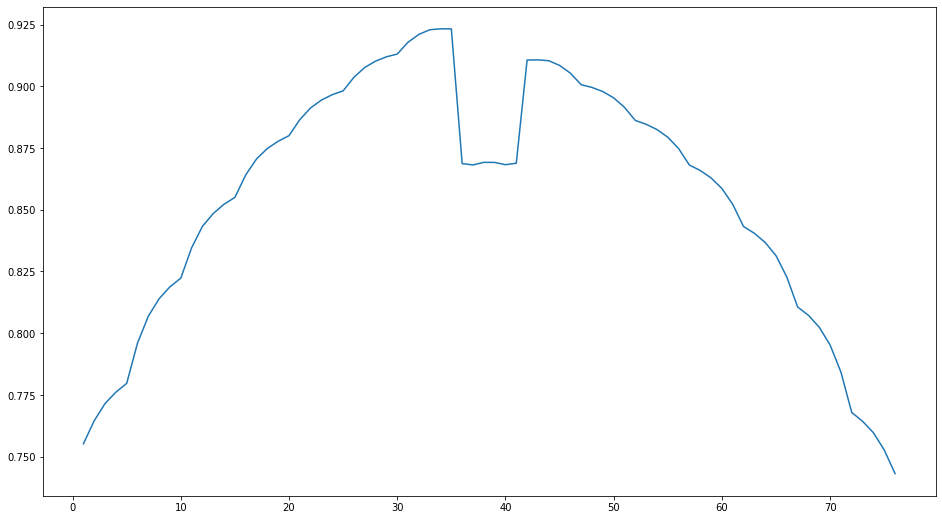

In [7]:
counts = [0] * 76
for n, rec in enumerate(bam.fetch('20', 0, 10000000)):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
        counts[i] += 1
freqs = [x / (n + 1.) for x in counts]
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(range(1, 77), freqs)

Finally, let's get the distribution of Phred scores across the mapped part of the reads. As you may suspect, this is probably not going to be uniform:

Here, we again use default dictionaries that allow you to use a bit of initialization code. We now fetch from start to end and create a list of Phred scores in a dictionary whose index is the relative position in the sequence read.

In [8]:
phreds = {}
for rec in bam.fetch('20', 0, None):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
      if i in phreds.keys():
        phreds[i].append(rec.query_qualities[i])
      else:
        phreds[i] = []

We then use NumPy to calculate the 95th, 50th (median), and 5th percentiles,
along with the maximum of quality scores per position. For most computational
biology analysis, having a statistical summarized view of the data is quite
common. So, you're probably already familiar with not only percentile
calculations, but also with other Pythonic ways to calculate means, standard
deviations, maximums, and minimums.

In [9]:
maxs = [max(phreds[i]) for i in range(76)]
tops = [np.percentile(phreds[i], 95) for i in range(76)]
medians = [np.percentile(phreds[i], 50) for i in range(76)]
bottoms = [np.percentile(phreds[i], 5) for i in range(76)]
medians_fig = [x - y for x, y in zip(medians, bottoms)]
tops_fig = [x - y for x, y in zip(tops, medians)]
maxs_fig = [x - y for x, y in zip(maxs, tops)]

Finally, we will perform a stacked plot of the distribution of Phred scores per
position. Due to the way matplotlib expects stacks, we have to subtract the value of the lower percentile from the one before with the stackplot call. We can use the list for the bottom percentiles, but we have to correct the median and the top as follows:

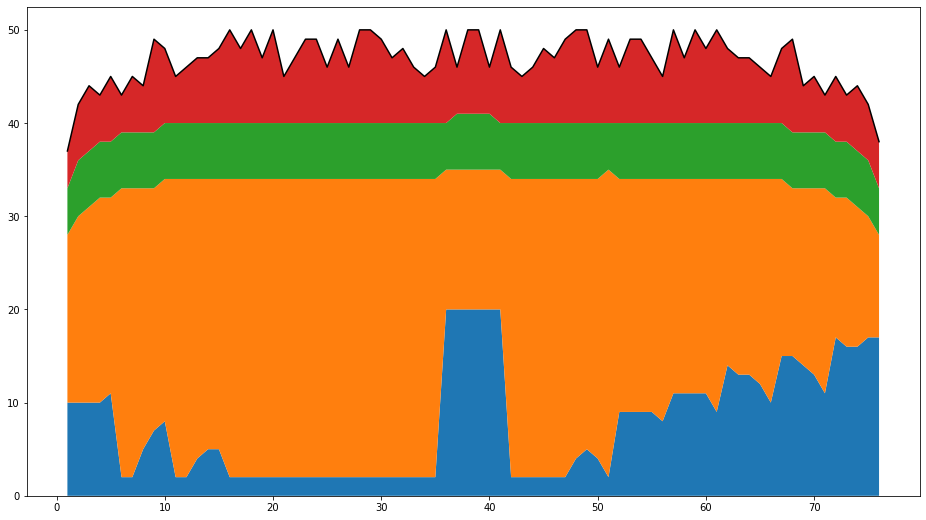

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(range(1, 77), (bottoms, medians_fig, tops_fig, maxs_fig))
ax.plot(range(1, 77), maxs, 'k-')